In [1]:
import sys
sys.path.append('../src')

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from utils import *

import seaborn as sns
sns.set()

## Statistical significance

Often we will want to make a distinction between two hypotheses based on data, we want to know whether one hypothesis is more likely than another based on the data we have. 

A statistical hypothesis test usually compares the observed results with those that would occur under the so-called "null hypothesis." This hypothesis posits, for example, that the data for the test and control groups are identical or that the differences in the results can be solely ascribed to random fluctuations rather than underlying effects.

Let's revisit our dataset from the previous lesson.

In [3]:
tweet_counts = tweets_data(mean=50, seed=484)

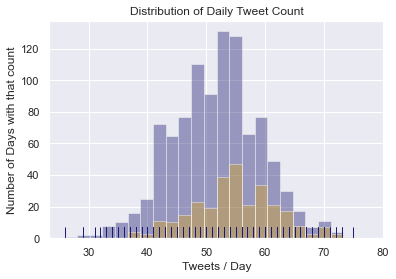

In [12]:
sample_mean = tweet_counts.mean()
bins = np.linspace(0.5*sample_mean, 1.5*sample_mean, 25)
weekend_msk = tweet_counts.index.map(lambda x: x.dayofweek in (5,6)).values
twoday_msk = tweet_counts.index.map(lambda x: x.dayofweek in (2,3)).values
ax = sns.distplot(
    tweet_counts, 
    bins=bins, 
    rug=True,
    kde=False,
    color='midnightblue',
)
ax = sns.distplot(
    tweet_counts[weekend_msk],
    bins=bins,
    rug=False,
    kde=False,
    color='goldenrod',
    ax=ax,
)
_ = ax.set_xlabel('Tweets / Day')
_ = ax.set_ylabel('Number of Days with that count')
_ = ax.set_title('Distribution of Daily Tweet Count')

It looks like the weekdays have a lower mean than the weekends, perhaps? How can we decide if that is a significant difference or not?

In [5]:
display(tweet_counts[weekend_msk].describe())
display(tweet_counts[np.logical_not(weekend_msk)].describe())

count    286.000000
mean      54.849650
std        7.166818
min       38.000000
25%       50.000000
50%       54.000000
75%       60.000000
max       75.000000
dtype: float64

count    714.000000
mean      50.488796
std        7.252065
min       26.000000
25%       46.000000
50%       51.000000
75%       55.000000
max       73.000000
dtype: float64

The means do differ but by less than either distribution's standard deviation. The two histograms are completely overlapping.

## Statistical Tests

A statistical test consists of a test statistic and its distribution. The general procedure is to calculate the statistic and then see what fraction of the distribution has more extreme values of the statistic.

Let's use our tweet data as an example and run the two-sample t-test to determine whether the observed difference in means is significant.

In [6]:
stats.ttest_ind(tweet_counts[np.logical_not(weekend_msk)], tweet_counts[weekend_msk])

Ttest_indResult(statistic=-8.621765996954668, pvalue=2.555337344825485e-17)

In [7]:
sample_sizes = [5, 10, 25, 50, 100]
for sample_size in sample_sizes:
    print(f"{sample_size} points from each: ", stats.ttest_ind(
        tweet_counts[np.logical_not(weekend_msk)].sample(sample_size), 
        tweet_counts[weekend_msk].sample(sample_size)
    ))

5 points from each:  Ttest_indResult(statistic=-1.6073673796734944, pvalue=0.14664073512148978)
10 points from each:  Ttest_indResult(statistic=-1.6067956679784843, pvalue=0.125498901180735)
25 points from each:  Ttest_indResult(statistic=-2.3249025072574945, pvalue=0.024352971212103128)
50 points from each:  Ttest_indResult(statistic=-2.471285147067676, pvalue=0.01518816691728996)
100 points from each:  Ttest_indResult(statistic=-5.176349588253852, pvalue=5.535920482855567e-07)


In [8]:
continuous1 = continuous_data_one()
display(continuous1.describe())
display(continuous1.notnull().sum())

count    1000.000000
mean      100.840778
std        26.241970
min        12.285102
25%        81.658418
50%       100.589504
75%       119.491412
max       181.815620
dtype: float64

1000

(-20.0, 20.0)

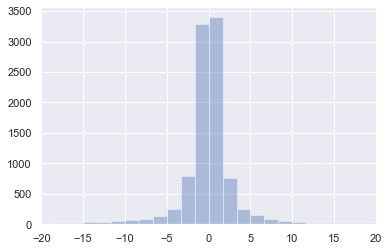

In [9]:
bins = np.linspace(-20,20,25)
ax = sns.distplot(np.random.standard_cauchy(10000), bins=bins, kde=False)
ax.set_xlim(-20,20)

In [10]:
stats.ttest_ind(np.random.standard_cauchy(100), continuous_data_one(mean=0, size=100))

Ttest_indResult(statistic=-0.25319123998898113, pvalue=0.8003831225395359)

In [11]:
d1 = add_nan(continuous_data_one(mean=0))
d2 = add_nan(np.random.standard_cauchy(1000)) + 0.5*d1
df = pd.DataFrame(data=[d1, d2])
df.T.corr()

,0,1
0,1.000000,0.200109
1,0.200109,1.000000
